# Exercise:  GeeMap, GEE, and Sentinel-2 data

This lesson is modified from [An Introduction to Cloud-Based Geospatial Analysis with Earth Engine and Geemap](https://geemap.org/workshops/AGU_2023/). Codes, annotation, and formatting are produced wuth assistant from Jupter AI using ChatGPT 3.5 Turbo and ChatGPT4o.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aselshall/eds/HEAD)

-----

## 1. Environment Setup

You need to install [GeeMap](https://geemap.org/) library. Installing geemap library can take more than 5 minutes depending on the specs of your machine.

In [1]:
#pip install geemap

You need to [register](https://code.earthengine.google.com/register) to [Google Earth Engine](https://earthengine.google.com/)  and follow the instructions [here]( https://docs.google.com/document/d/1ZGSmrNm6_baqd8CHt33kIBWOlvkh-HLr46bODgJN1h0/edit?usp=sharing) to create a Cloud Project. 

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
If you have an Earth Engine account with your university email but have not used the Earth Engine Python API,  creating a new account with your personal Gmail is a good idea. The API needs a Google Cloud Project, which universities may restrict users from creating.
</div>

In [2]:
#pip install earthengine-api

Running the following cell will start the Earth Engine authentication. Follow the instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication) to authenticate Earth Engine.

In [3]:
# import ee
# ee.Authenticate()
# ee.Initialize()

In [4]:
import ee

# Function to read the authorization code from a file
def read_auth_code(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()

# Read the authorization code
auth_code = read_auth_code('auth_code.txt')

# Authenticate using the authorization code
# Note: Use the 'ee.Authenticate()' method without parameters
ee.Authenticate()

# After calling ee.Authenticate(), you will need to manually input the 
# authorization code obtained from the 'auth_code.txt' file in the console
print("Please enter the authorization code from 'auth_code.txt' after running ee.Authenticate().")

# Initialize the Earth Engine
ee.Initialize()

Please enter the authorization code from 'auth_code.txt' after running ee.Authenticate().


### 2. Import Libraries

Import geemap and run the code below. If you can see the image then geemap is working. If you cannot see the image close your JupyterLab and reopen it again.

In [5]:
#jupyter nbextension enable --py widgetsnbextension

In [6]:
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


In [7]:
m =geemap.Map(center=[26.465, -81.775], zoom=17)

m

Map(center=[26.465, -81.775], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

To learn how to use Google Earth engine (gee) and geemap package, please check the [geemap developer's YouTube channel](https://www.youtube.com/@giswqs). As a start please check the playlist of [Earth Engine and Geemap Workshops](https://www.youtube.com/playlist?list=PLAxJ4-o7ZoPeeJZL-_3kcZ2WLYF5x87eX). You need to have an idea about GEE and geemap before you do this exercise.

## 3. Exercise

There are several remote sensing indices that can be useful for studying harmful algal blooms (HABs) in Big Cypress, Florida that include normalized difference chlorophyll index (NDCI), turbidity, water vegetation index (WVI), chlorophyll-a concentration, normalized difference water index (NDWI), floating algae index (FAI) and so on. 

This example shows the workflow for Sentinel-2 data and GEE to study time series changes in NDCI, turbidity and WVI.

**[Normalized Difference Chlorophyll Index (NDCI)](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndci/)**   
used to estimate chlorophyll concentration in water bodies, indicating the presence of algae and phytoplankton.
$$
\text{NDCI} = \frac{(\text{B5} - \text{B4})}{(\text{B5} + \text{B4})}
$$

Bands Used:
- B5 (Red Edge)
- B4(Red)

**[Turbidity](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/se2waq/)**   
measures the cloudiness or haziness of water caused by suspended particles, which can affect light penetration and water quality.
$$
\text{Turbidity} = 8.93 \left(\frac{\text{B3}}{\text{B1}}\right) - 6.39
$$

Bands Used:
- B3 (Green)
- B1 (Coastal Aerosol- Blue)


**[Water Vegetation Index (WVI)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111878/)**  
used to assess the vegetation health and extent in water-related environments such as wetlands, by combining normalized difference vegetation index (NDVI) that measures live green vegetation, and the modified normalized difference water index (MNDWI) that better distinguishes water bodies such as lakes, and rivers.

$$
\text{WVI} = \text{NDVI} + \text{MNDWI}
$$
Where:
$$
\text{NDVI} = \frac{(\text{B8} - \text{B4})}{(\text{B8} + \text{B4})}
$$
$$
\text{MNDWI} = \frac{(\text{B3} - \text{B11})}{(\text{B3} + \text{B11})}
$$

Bands Used:
- B8 (Near Infrared - NIR)
- B4 (Red)
- B3 (Green)
- B11 (Shortwave Infrared - SWIR1)
3 (Green)
- B11 (Shortwave Infrared - SWIR1)


Similarly we can also consider:
- **[Chlorophyll-a concentration](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/)** to directly measures the concentration of chlorophyll-a as key indicator of algal biomass
- **[Normalized difference water index (NDWI)](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/)** to monitor changes in water content of water bodies
- **[Floating algae index (FAI)](https://forum.sentinel-hub.com/t/floating-algae-monitoring-with-s-2-and-s-3/1867)** to detect floating algae in water bodies
- **[Water In Wetlands Index (WIW)](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/wiw_s2_script/)** to generate water maps by featuring water in blue and other landscape features in natural colors

Check [Sentinel-hub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/) for more details about these indicies, code snippets, and more indicies that you can use.

The purpose of this exercise is to illustrate the workflow using NDCI, Turbidity, and WVI indicies as examples.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
Bofore starting this exercise you need to set up Google Earth Engine (GEE) and important geemap as shown above.
</div>

### 3.1 Select an area of interest in Big Cypress, Florida

Use coordinates to define your area of interest (AOI). You can obtain the boundaries from a shapefile, or you can manually digitize your AOI using geemap. Here we will select a polygon at our study area.

In [8]:
# Define the AOI using a polygon
aoi = ee.Geometry.Polygon([
  [
    [-81.4, 25.9],
    [-81.4, 25.7],
    [-81.2, 25.7],
    [-81.2, 25.9]
  ]
])

# Create a map centered on the AOI
Map = geemap.Map(center=[25.8, -81.3], zoom=10)

# Add a high-resolution satellite image as the basemap
#Map.add_basemap('SATELLITE')


# Add the AOI to the map
Map.addLayer(aoi, {}, 'AOI')

# Display the map
Map

Map(center=[25.8, -81.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

### 3.2 Import and process Sentinel-2 data

This step filters Sentinel-2 data and calculate the necessary indices.

#### 3.2.1 Import Sentinel-2 data

From GEE the Sentinel-2 Level-2A surface reflectance image collection [COPERNICUS/S2_HARMONIZED](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) is imported and filtered by bounds, date, and cloud cover. The code below will initializes the Sentinel-2 image collection from the GEE catalog. Then will filter the image collection to include only images that intersect with AOI, taken with defined time range, and with less than 20% cloud cover.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
COPERNICUS/S2_HARMONIZED provides harmonized Sentinel-2 surface reflectance imagery. This collection combines data from Sentinel-2A and Sentinel-2B satellites and ensures consistent data quality across both satellites. It applies atmospheric correction to convert the top-of-atmosphere (TOA) reflectance values to surface reflectance values.
</div>

In [9]:
# Import Sentinel-2 image collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
  .filterBounds(aoi) \
  .filterDate('2019-01-01', '2023-12-31') \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# Display the collection size to verify the filtering
print('Number of images in the filtered collection:', sentinel2.size().getInfo())

Number of images in the filtered collection: 355


You could also further filter images to a specific dates such as a specific season or month.

```python
# Import Sentinel-2 image collection and apply the season filter
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
  .filterBounds(aoi) \
  .filterDate('2016-01-01', '2023-12-31') \
  .filter(ee.Filter.calendarRange(6, 8, 'month')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
```

The `.filter(ee.Filter.calendarRange(6, 8, 'month'))` selects images captured between June and August of each year within the specified date range. You can also select specific dates using `ee.Date()` such as `ee.Date.fromYMD(year, 8, 31)` to select a specific day as a start or end date for example.For details, you can check [Harmonization of Landsat and Sentinel 2 in Google Earth Engine, documentation and scripts](
https://github.com/ndminhhus/geeguide/tree/maste). You can also use AI coding assistance.a

#### 3.2.2 View Sentinel-2 data

Before any data processing let use geemap to visualize Sentinel-2 data for the given AOI.

In [10]:
# Create a map centered on the AOI
# Creates a map object centered at the specified latitude and longitude (25.8, -81.3) with a zoom level of 10.
Map = geemap.Map(center=[25.8, -81.3], zoom=10)

#Select an image
# These are examples for some selections that you can make
#first_image = sentinel2.first().clip(aoi)                             #first image
#specific_image = sentinel2.toList(sentinel2.size()).get(4).clip(aoi)  #Fifth image
#image_with_specific_date = sentinel2.filterDate('2020-06-15', '2020-06-15').first().clip(aoi)
#image_with_lowest_cloud_coverage = sentinel2.sort('CLOUDY_PIXEL_PERCENTAGE').first().clip(aoi)

# Select the median image
# Reduces the image collection to a single image 
# by taking the median value of each pixel across all images in the collection.
# Clips the median image to the boundaries of the AOI 
median_image = sentinel2.median().clip(aoi)


# Define visualization parameters
vis_params = {
   # Specifies the bands used for visualization. B4 (Red), B3 (Green), and B2 (Blue) are selected for a true color image
  'bands': ['B4', 'B3', 'B2'],  # True color visualization
   # Defines the range of values to display. Pixel values between 0 and 3000 will be mapped to the color range
  'min': 0,
  'max': 3000,
  # Adjusts the gamma correction to enhance the visual contrast of the image
  'gamma': 1.4,
}

# Add the Sentinel-2 image to the map
# Adds the median image layer to the map using the specified visualization parameters.
# The layer is labeled 'Sentinel-2' in the map's layer control
Map.addLayer(median_image, vis_params, 'Sentinel-2')

# Add the AOI to the map
# Adds the area of interest (AOI) as a layer on the map. 
# The AOI layer is labeled 'AOI' in the map's layer control
Map.addLayer(aoi, {}, 'AOI')

# Display the map
# Adds a layer control to the map, allowing users to toggle the visibility of different layers.
Map.addLayerControl()  # Add layer control to toggle layers on/off

# Displays the map with the added layers and controls.
Map

Map(center=[25.8, -81.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

#### 3.2.3 Define and calcuate indices for each image

Let us define functions that we can use to calcuate NDCI, turbidity and WVI. We use the equations with the bands shown above.  
  
Then we can use the `map` method to apply specified functions to each image in the sentinel2 image collection.Each function (`calculateNDCI`, `calculateTurbidity`, `calculateWVI`) calculates a specific index for an image and adds that index as a new band to the image. The result is a new image collection called `processed_images` where each image now contains additional bands for NDCI, Turbidity, and WVI. By processing each image to include these additional bands, we prepare the dataset for further analysis and visualization. 


In [11]:
# Define indices calculation functions
def calculate_indices(image):
    ndci = image.normalizedDifference(['B5', 'B4']).rename('NDCI')
    turbidity = (image.select('B3')  # Select band B3
                .divide(image.select('B1'))  # Divide B3 by B1
                .multiply(8.93)          # Multiply the result by 8.93
                .subtract(6.39)        # Subtract 6.39 from the result
                .rename('Turbidity')         # Rename the resulting band to 'Turbidity
                )
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    wvi = ndvi.add(mndwi).rename('WVI')
    return image.addBands([ndci, turbidity, wvi])

# Apply the calculation functions
processed_images = sentinel2.map(calculate_indices)

# Print the bands of the first image to verify
# Get the first image from the processed collection
# Get the band names of the first image
first_image_bands = processed_images.first().bandNames().getInfo()
print('Bands in the first processed image:', first_image_bands)

Bands in the first processed image: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDCI', 'Turbidity', 'WVI']


#### 3.3.4 Visualize NDCI, Turbidity, and WVI

Now let us visualize the NDCI, Turbidity, and WVI bands on the map using geemap.

In [12]:
# # Create a map centered on the AOI
# Map = geemap.Map(center=[25.8, -81.3], zoom=8)

# # Add the NDCI layer to the map
# ndci_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
# Map.addLayer(processed_images.select('NDCI').mean(), ndci_params, 'NDCI')

# # # Add the Turbidity layer to the map
# # turbidity_params = {'min': 0, 'max': 10, 'palette': ['blue', 'white', 'red']}
# # Map.addLayer(processed_images.select('Turbidity').mean(), turbidity_params, 'Turbidity')

# # # Add the WVI layer to the map
# # wvi_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
# # Map.addLayer(processed_images.select('WVI').mean(), wvi_params, 'WVI')

# # Display the map
# Map

We now have defined our data and we are ready to do some analysis.

### 3.3 Perform Time Series Analysis

In this step we define a function to calculate the mean values of specific indices (NDCI, Turbidity, and WVI) over time for each image in the collection and then generate time series data for these indices.

#### 3.3.1 Calculate mean values over time

The `calculate_time_series(image_collection, index_name)` function takes an image collection and the name of an index (e.g., 'NDCI', 'Turbidity', 'WVI') and returns a time series of mean values for the specified index over time. The nested function `reduce_region(image)` reduces each image in the collection to its mean value over the AOI. 

<div class="admonition alert alert-info" >
    <p class="admonition-title" style="font-weight:bold">Note</p>
Sometime the below function will take overever to run. In that case restart kernel and clear all outputs. This will fix the problem.
</div>

In [13]:
# Function to calculate mean values over time
def calculate_time_series(image_collection, index_name):
    # Inner function to reduce each image to a mean value over the AOI
    def reduce_region(image):
        # Calculate mean value for the specified index over the AOI
        stats = image.reduceRegion(      # Computes the mean value of the specified index over the AOI.
            reducer=ee.Reducer.mean(),   # Specifies that we want to calculate the mean
            geometry=aoi,                # Area of Interest (AOI) over which to calculate the mean
            scale=10,                    # Spatial resolution in meter at which to perform the calculation (e.g. 10 meters)
            maxPixels=1e9                # Max number of pixels to include in the calculation (large number ensures completeness)
        )

        #Converts the result to a feature and adds the date of the image to the feature
        return ee.Feature(None, stats).set('date', image.date().format('YYYY-MM-dd'))

    # Apply the reduce_region function to each image in the collection
    # Maps the reduce_region function over the entire image collection, 
    # resulting in a collection of features with mean index values and dates
    time_series = image_collection.map(reduce_region)

    # Converts the collection of features to a list of date-index value pairs.
    time_series_list = time_series.reduceColumns(
        ee.Reducer.toList(2),            #  Aggregates the results into a list
        ['date', index_name]             # Specifies the properties to include in the list (date and the specified index).
    ).get('list').getInfo()              # Retrieves the list from the server as a Python object

    # Return the time series list
    return time_series_list

# Calculate time series for each index
# apply the calculate_time_series function 
# to the processed_images collection for each index (NDCI, Turbidity, and WVI)
ndci_time_series = calculate_time_series(processed_images, 'NDCI')    
turbidity_time_series = calculate_time_series(processed_images, 'Turbidity') 
wvi_time_series = calculate_time_series(processed_images, 'WVI')     

# Convert time series to pandas DataFrame
def time_series_to_df(time_series, index_name):
    df = pd.DataFrame(time_series, columns=['date', index_name])
    df['date'] = pd.to_datetime(df['date'])
    return df
ndci_df = time_series_to_df(ndci_time_series, 'NDCI')
turbidity_df = time_series_to_df(turbidity_time_series, 'Turbidity')
wvi_df = time_series_to_df(wvi_time_series, 'WVI')

# Merge dataframes for analysis
merged_df = pd.merge(pd.merge(ndci_df, turbidity_df, on='date'), wvi_df, on='date')

# Save data to CSV
ndci_df.to_csv('NDCI_TimeSeries_BigCypress.csv', index=False)
turbidity_df.to_csv('Turbidity_TimeSeries_BigCypress.csv', index=False)
wvi_df.to_csv('WVI_TimeSeries_BigCypress.csv', index=False)
merged_df.to_csv('Merged_TimeSeries_BigCypress.csv', index=False)

#### 3.3.2 Plot time series

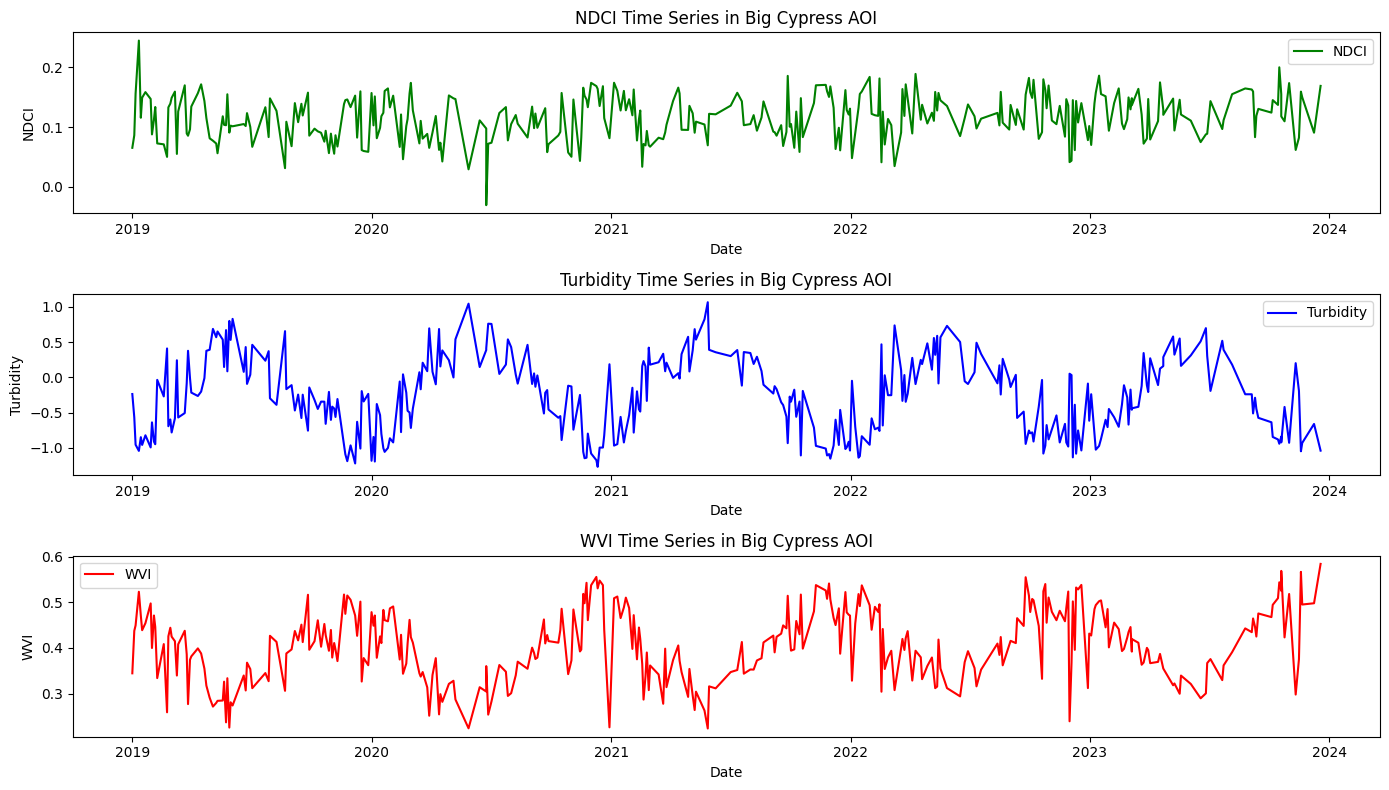

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(14, 8))

# Plot NDCI time series
axs[0].plot(ndci_df['date'], ndci_df['NDCI'], label='NDCI', color='green')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('NDCI')
axs[0].set_title('NDCI Time Series in Big Cypress AOI')
axs[0].legend()

# Plot Turbidity time series
axs[1].plot(turbidity_df['date'], turbidity_df['Turbidity'], label='Turbidity', color='blue')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Turbidity')
axs[1].set_title('Turbidity Time Series in Big Cypress AOI')
axs[1].legend()

# Plot WVI time series
axs[2].plot(wvi_df['date'], wvi_df['WVI'], label='WVI', color='red')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('WVI')
axs[2].set_title('WVI Time Series in Big Cypress AOI')
axs[2].legend()

plt.tight_layout()
plt.show()

### 3.4 Statistical analysis

#### 3.41 Correlation matrix and heatmap 
Correlation matrix and heatmap display correlations between multiple variables, and how variables are related to each other, with darker colors indicating stronger correlations. Let us calculate and plot correlation coefficient to determine linear relationship between indices.

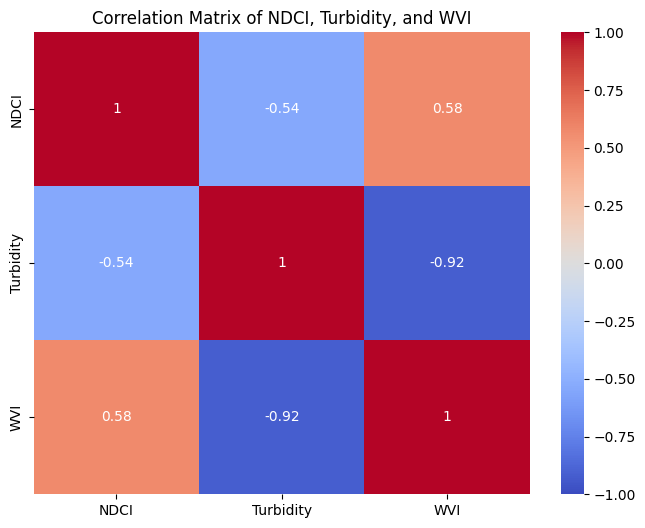

Correlation Matrix:
                NDCI  Turbidity       WVI
NDCI       1.000000  -0.540212  0.576418
Turbidity -0.540212   1.000000 -0.920885
WVI        0.576418  -0.920885  1.000000


<Figure size 640x480 with 0 Axes>

In [15]:
# Correlation Analysis
corr_matrix = merged_df[['NDCI', 'Turbidity', 'WVI']].corr()

# Plotting Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of NDCI, Turbidity, and WVI')
plt.show()

# Print Correlation Matrix
plt.savefig('heat_map.png')  # Save the figure
print("Correlation Matrix:\n", corr_matrix)


A heat map would show the strength of correlation between different indices (NDCI, Turbidity, WVI). 
- High positive values (closer to 1) indicate a strong positive correlation
- High negative values (closer to -1) indicate a strong negative correlation.
- Values near zero suggest no significant correlation.

#### 3.4.2 Scatter plots

Scatter plots show relationships between two variables to identify patterns and correlations in data, to spot outliers and to understand the strength and direction of relationships between variables.

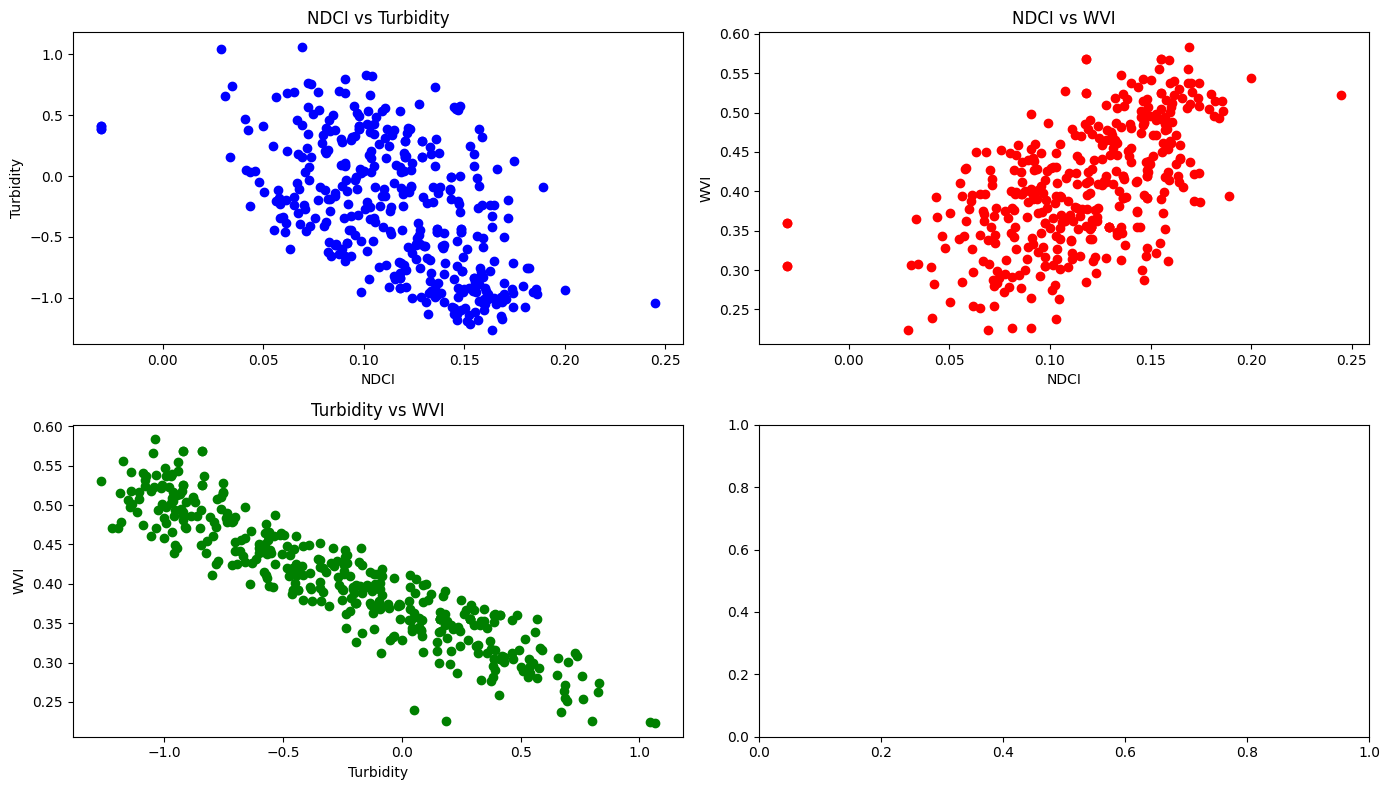

In [16]:
# Scatter Plot Analysis
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].scatter(merged_df['NDCI'], merged_df['Turbidity'], c='blue')
axs[0, 0].set_xlabel('NDCI')
axs[0, 0].set_ylabel('Turbidity')
axs[0, 0].set_title('NDCI vs Turbidity')

axs[0, 1].scatter(merged_df['NDCI'], merged_df['WVI'], c='red')
axs[0, 1].set_xlabel('NDCI')
axs[0, 1].set_ylabel('WVI')
axs[0, 1].set_title('NDCI vs WVI')

axs[1, 0].scatter(merged_df['Turbidity'], merged_df['WVI'], c='green')
axs[1, 0].set_xlabel('Turbidity')
axs[1, 0].set_ylabel('WVI')
axs[1, 0].set_title('Turbidity vs WVI')

plt.tight_layout()
plt.savefig('Scatter_plot.png')  # Save the figure
plt.show()

**Interpretation:** 
- As the chlorophyll concentration (indicated by NDCI) increases, turbidity tends to decrease. This does not make sense as higher chlorophyll levels (algae) is generally not associated with clearer water. However, in this specific area this might be possible due to settling of particles. Or this could be a calculation error!
- Higher values of chlorophyll concentration (NDCI) are associated with higher water vegetation health (WVI). This suggests that areas with more chlorophyll (algae) also have healthier or more abundant water-related vegetation
- As turbidity increases, the health of water-related vegetation (WVI) decreases. High turbidity, which indicates more suspended particles in the water, might reduce light penetration, adversely affecting aquatic vegetation. Thus, that it makes sense that clearer water conditions (lower turbidity) can lead to healthier water vegetation.

#### 3.4.3 Trend analysis

We can use trend analysis (seasonal decomposition) to analyze the time series data of three indices: NDCI, Turbidity, and WVI. Seasonal decomposition helps us understand the underlying patterns in the time series data by breaking it down into three components: trend, seasonal, and residual components:
- Trend: The long-term movement in the data.
- Seasonal: The repeating short-term cycle in the data.
- Residual: The remaining noise or random fluctuations after removing the trend and seasonal components.

By decomposing the time series for NDCI, Turbidity, and WVI, we can better understand the long-term trends, seasonal patterns, and any residual noise in the data. 

We can use the `seasonal_decompose` function from the statsmodels library to perform this decomposition.

In [17]:
#Plotting function to be called as needed
def plot_seasonal_decomposition(result, title, file_name):
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    result.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)
    result.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

    # Format x-axis labels to be more readable
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

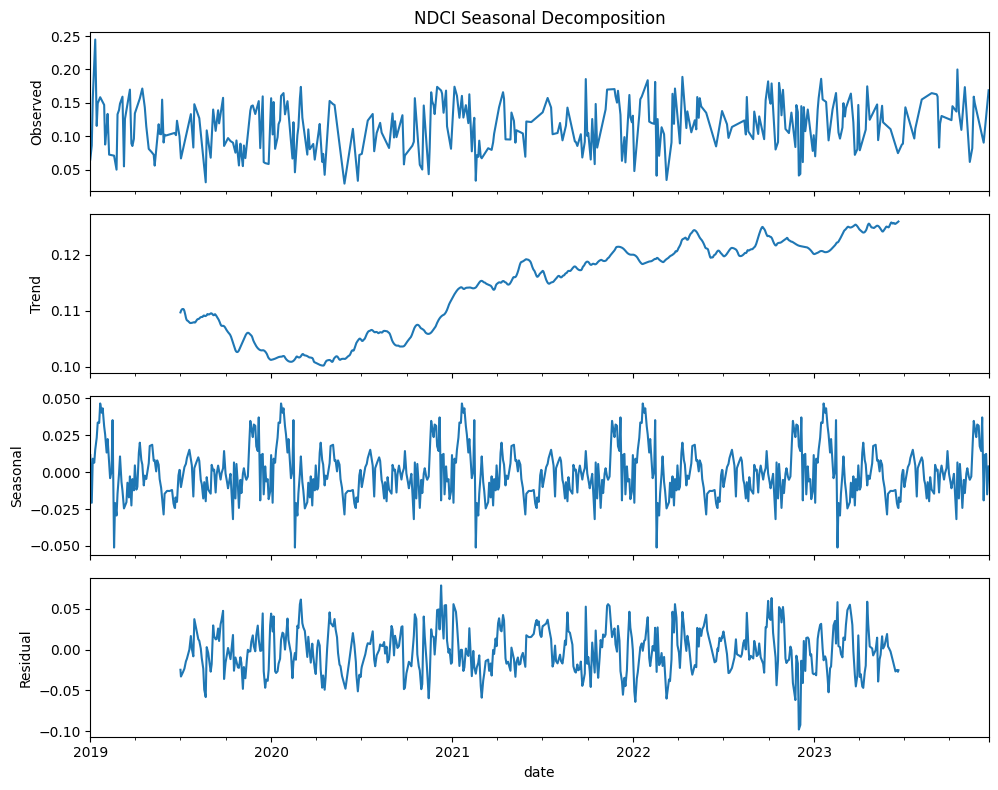

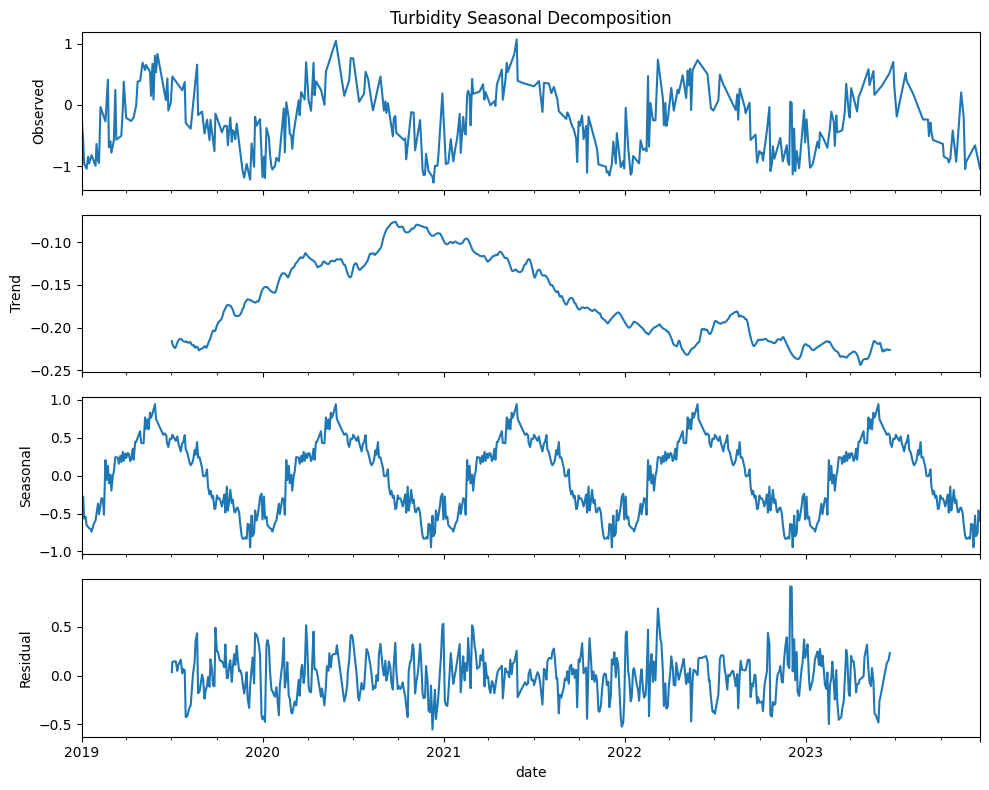

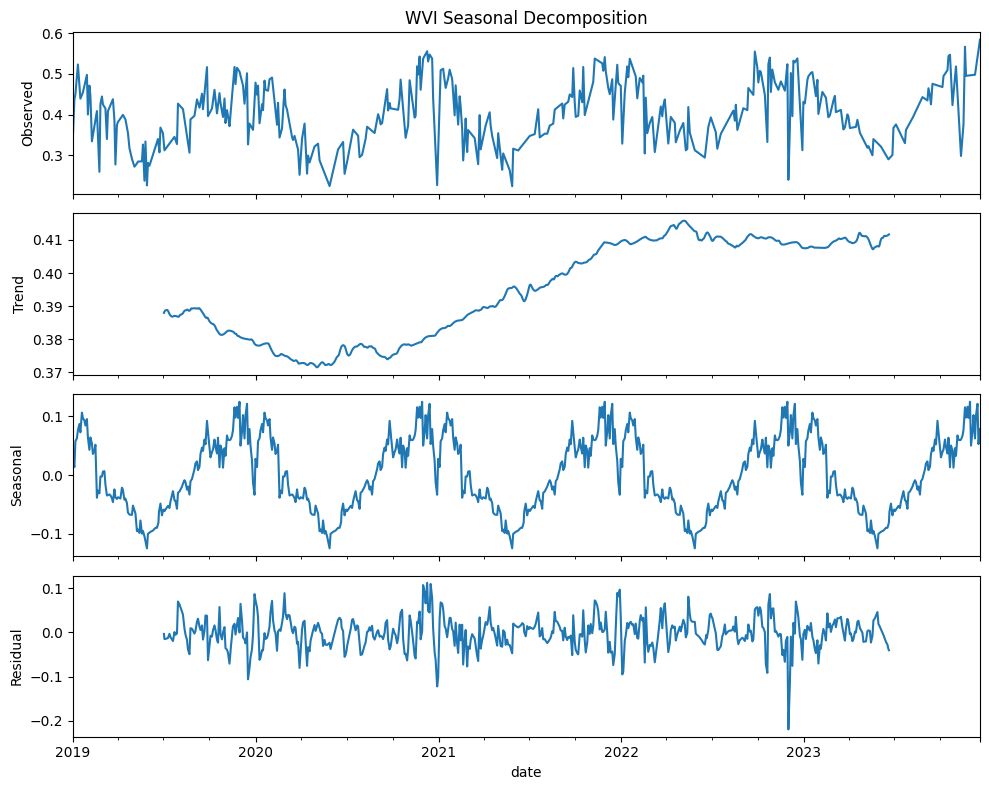

In [18]:
# Ensure that the 'date' column is in datetime format and set it as the index
merged_df.index = pd.to_datetime(merged_df.date)

# Remove or aggregate duplicates by taking the mean for each date
merged_df = merged_df.groupby(merged_df.index).mean()

# Resample the data to a daily frequency and interpolate missing values
df_resampled = merged_df.resample('D').interpolate()

# Set the period for seasonal decomposition (e.g., 365 for yearly seasonality)
period = 365

# Decompose and plot the NDCI time series
result_ndci = seasonal_decompose(df_resampled['NDCI'], model='additive', period=period)
plot_seasonal_decomposition(result_ndci, 'NDCI Seasonal Decomposition', 'NDCI_seasonal_decomposition_custom.png')

# Decompose and plot the Turbidity time series
result_turbidity = seasonal_decompose(df_resampled['Turbidity'], model='additive', period=period)
plot_seasonal_decomposition(result_turbidity, 'Turbidity Seasonal Decomposition', 'Turbidity_seasonal_decomposition_custom.png')

# Decompose and plot the WVI time series
result_wvi = seasonal_decompose(df_resampled['WVI'], model='additive', period=period)
plot_seasonal_decomposition(result_wvi, 'WVI Seasonal Decomposition', 'WVI_seasonal_decomposition_custom.png')


**NDCI (Normalized difference chlorophyll index)**  
- Gradual increase in chlorophyll concentration over time suggest possible increase in algal blooms or vegetation
- Seasonal patterns in chlorophyll concentration could be due to climatic conditions or human activities 
- Residuals are fairly consistent and centered around zero, indicating that the model has captured most of the variability with the trend and seasonal components

**Turbidity**
- Gradual reduction in turbidity levels over times suggesting improvements in water clarity or reductions in sediment or pollution levels
- Periodic fluctuations suggest that turbidity levels are influenced by seasonal factors such as rainfall, runoff, or human activities
- Residuals are more dispersed than those for NDCI meaning more unexplained variability

**WVI (Water vegetation index)**
- Increase in water vegetation health and extent over time could be due to environmental changes, conservation efforts, or other factors enhancing vegetation growth. Plants could be stressed due pollution, invasive species, or changes in hydrology. Also, vegetation health indicates the wetland's capacity to filter pollutants, regulate water flow, and maintain water quality. This can also suggest less over-irrigation leading to waterlogging and nutrient leaching. Climate change can also impact vegetation health by altering precipitation patterns, and temperature. Changes in land use (e.g., urbanization, deforestation, or agricultural expansion) can affect water-related vegetation. Conservation efforts such as wetland restoration projects also has an impact. There can be also stress due to due to pollution such as runoff from agricultural fields containing high levels of nutrients (nitrogen and phosphorus) and pesticides. These are some of the drivers that can be invistigated.
- Seasonal component shows clear periodic variations mainly due seasonal growth and decay cycles of water vegetation
- Residuals indicated that the seasonal decomposition model has effectively captured the main patterns in the data

**Some key points:**
- Increasing trends in both NDCI and WVI suggest a rise in chlorophyll concentration and water vegetation over time. One reason for this is increased nutrient levels leading to more algal growth and vegetation
- Decreasing trend in turbidity suggests improving water clarity that could be due to some water management practices that we can identify
- All three indices show strong seasonal patterns, highlighting the influence of seasonal climatic factors. Understanding these patterns can help in planning and managing water resources
- Residuals for all three indices indicates the decomposition model has successfully captured the primary trends and seasonal variations

#### 3.4.4 Regression analysis

Ordinary least squares (OLS) regression model assesses the relationship between the dependent variable (WVI) and two independent variables (NDCI and Turbidity).

In [19]:
# Regression Analysis
X = merged_df[['NDCI', 'Turbidity']]
X = sm.add_constant(X)  # Adding a constant
y = merged_df['WVI']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    WVI   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1146.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          7.38e-154
Time:                        11:57:22   Log-Likelihood:                 759.22
No. Observations:                 351   AIC:                            -1512.
Df Residuals:                     348   BIC:                            -1501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3390      0.005     63.266      0.0

Key Statistics and interpretation
- Adj R-squared 0.868 indicates that 86.7% of the variability in WVI can be explained by the model. Note that adjusted R-squared accounts for the number of predictors in the model.
- The p-value associated with the F-statistic (7.39e-154) indicats the model is highly significant (p < 0.05). Both NDCI and Turbidity are significant predictors of WVI. NDCI has a positive relationship, while Turbidity has a negative relationship with WVI. The model fit is strong, and the predictors are statistically significant, making the model useful for understanding the relationships between these indices.
- Durbin-Watson: 1.622 for the presence of autocorrelation in the residuals, which is close to 2, suggesting no autocorrelation. However, the Prob(Omnibus) with p-value 0.019 suggests that the residuals are not perfectly normal (p < 0.05).
We see here the same story that we saw above. The regression model shows that WVI is significantly influenced by both NDCI and Turbidity. An increase in NDCI leads to an increase in WVI, suggesting healthier water-related vegetation with higher chlorophyll levels. Conversely, an increase in Turbidity leads to a decrease in WVI, indicating that higher turbidity negatively impacts water-related vegetation health. 

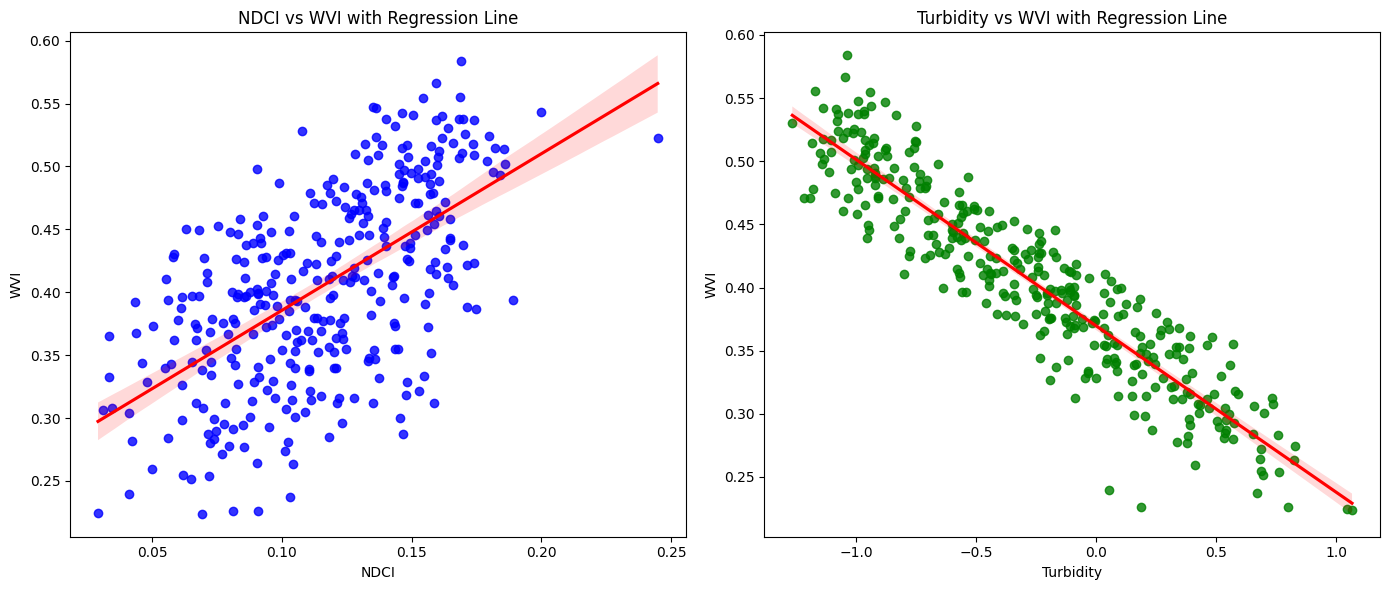

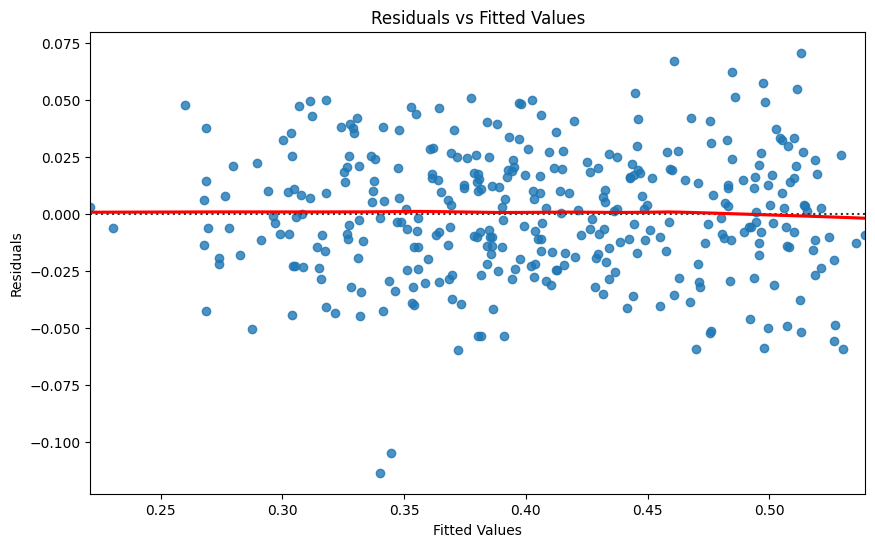

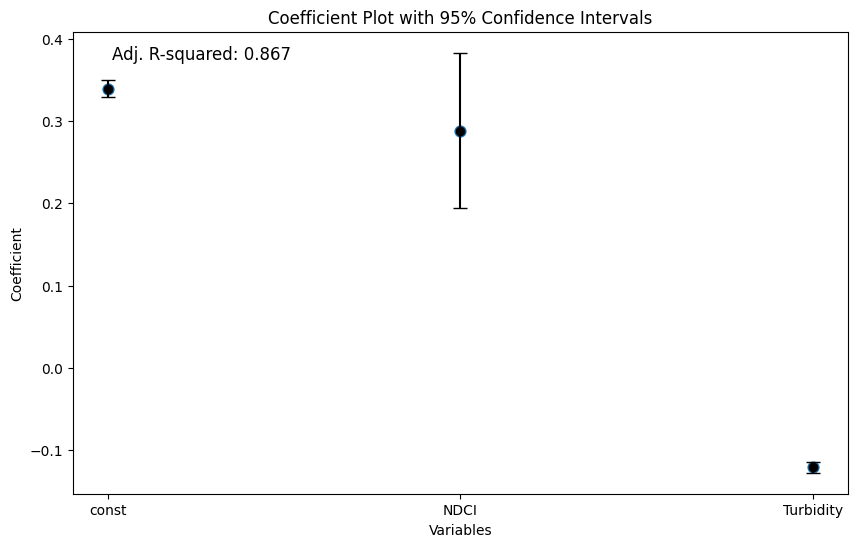

In [20]:
# This code is generated by ChatGPT4o.
# Scatter plots with regression lines
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# NDCI vs WVI
sns.regplot(x='NDCI', y='WVI', data=merged_df, ax=axs[0], color='blue', line_kws={'color': 'red'})
axs[0].set_title('NDCI vs WVI with Regression Line')
axs[0].set_xlabel('NDCI')
axs[0].set_ylabel('WVI')

# Turbidity vs WVI
sns.regplot(x='Turbidity', y='WVI', data=merged_df, ax=axs[1], color='green', line_kws={'color': 'red'})
axs[1].set_title('Turbidity vs WVI with Regression Line')
axs[1].set_xlabel('Turbidity')
axs[1].set_ylabel('WVI')

plt.tight_layout()
plt.show()

# Residuals Plot
residuals = model.resid

plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Coefficient Plot
coefficients = model.params
conf = model.conf_int()
conf['Coefficient'] = coefficients
conf.columns = ['Lower Bound', 'Upper Bound', 'Coefficient']

plt.figure(figsize=(10, 6))
sns.pointplot(x=conf.index, y='Coefficient', data=conf, join=False)
plt.errorbar(x=conf.index, y=conf['Coefficient'], yerr=[conf['Coefficient'] - conf['Lower Bound'], conf['Upper Bound'] - conf['Coefficient']], fmt='o', color='black', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot with 95% Confidence Intervals')

# Add Adj. R-squared annotation
adj_r_squared = model.rsquared_adj
plt.annotate(f'Adj. R-squared: {adj_r_squared:.3f}', xy=(0.05, 0.95), 
             xycoords='axes fraction', fontsize=12, ha='left', va='center')

plt.show()


The coef. plot visually confirms the statistical significance and direction of the relationships between the predictors (NDCI and Turbidity) and the response variable (WVI) supporting the conclusions drawn from the regression summary.
- NDCI has a positive coefficient, meaning that higher NDCI values (indicative of higher chlorophyll concentration) are associated with higher WVI (better water vegetation health)
- Turbidity has a negative coefficient, indicating that higher turbidity levels (cloudier water) are associated with lower WVI (worse water vegetation health)
- Narrow confidence intervals, especially for the intercept and Turbidity, suggest that the estimates are precise and reliable

### Resources
- [Geemap Documentation](https://geemap.org/) for extensive examples and tutorials at the YouTube channel that will help you to learn geemap, GEE, and machine learning of GEE for [unsupervised classification](https://youtu.be/k9MEy2awVJQ?si=4anPnBaC2W12d4dn) and [supervised classification](https://youtu.be/qWaEfgWi21o?si=G3LyluK3DUtIPw8w) and codes at [Geemap GitHub Repository](https://github.com/gee-community/geemap)
- [Earth Engine Python API Documentation](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api) for detailed documentation and examples
- [Google Earth Engine YouTube Channel](https://www.youtube.com/@googleearth/playlists) for tutorials on various GEE functionalities and applications.
- AI coding assistants (e.g. ChatGPT), [Google Earth Engine Developers Community](https://groups.google.com/g/google-earth-engine-developers/about), and [Stack Overflow](https://stackoverflow.com/questions/tagged/google-earth-engine) to get help with specific issues.
- [Resource gallery of projectpythia](https://projectpythia.org/resource-gallery.html) for additional resources 